In [261]:
# Necessary imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

# Modelling packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
%matplotlib inline

In [262]:
# Import the data
tweets = pd.read_csv("C:/Users/rabia/Desktop/Thinkful/Final/tweets.csv")

# Preview the dataset
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
# View the size of the dataset
tweets.shape

(14640, 15)

In [263]:
# Condense dataframe to only include what we want
tweets = tweets[['airline_sentiment', 'negativereason', 'airline', 'text']]

In [120]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
airline_sentiment    14640 non-null object
negativereason       9178 non-null object
airline              14640 non-null object
text                 14640 non-null object
dtypes: object(4)
memory usage: 457.6+ KB


In [121]:
negative = tweets.loc[tweets['airline_sentiment'] == 'negative']
negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9178 entries, 3 to 14638
Data columns (total 4 columns):
airline_sentiment    9178 non-null object
negativereason       9178 non-null object
airline              9178 non-null object
text                 9178 non-null object
dtypes: object(4)
memory usage: 358.5+ KB


In [118]:
# Print unique airlines in the dataset
tweets['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [119]:
# Describe unique occurences for each categorical variable
tweets.nunique()

airline_sentiment        3
negativereason          10
airline                  6
text                 14427
dtype: int64

In [33]:
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

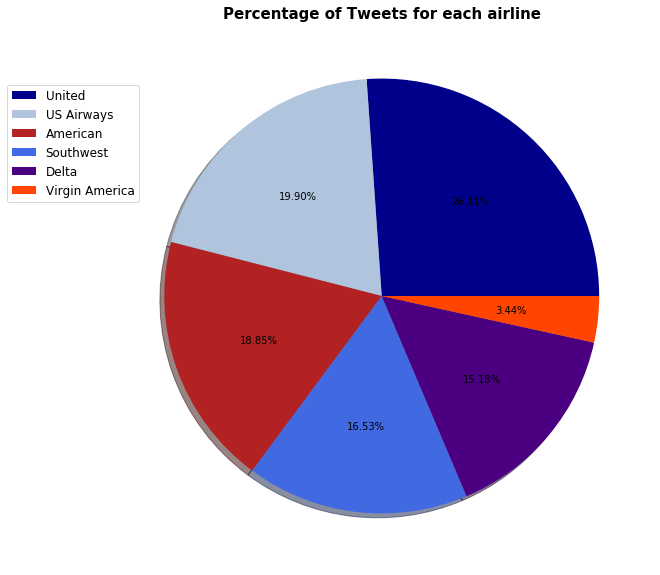

In [98]:
plt.figure(figsize=(18,10))

size = tweets['airline'].value_counts().tolist()
colors = ['darkblue', 'lightsteelblue', 'firebrick', 'royalblue', 'indigo', 'orangered']
labels = ['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America']
plt.pie(size, colors = colors, shadow = True, autopct = '%.2f%%')
plt.title('Percentage of Tweets for each airline', fontweight="bold", fontsize = 15)
plt.axis('off')
plt.legend(labels, bbox_to_anchor=(-0.2,0.9), prop={'size': 12}, loc="upper left")
plt.show()

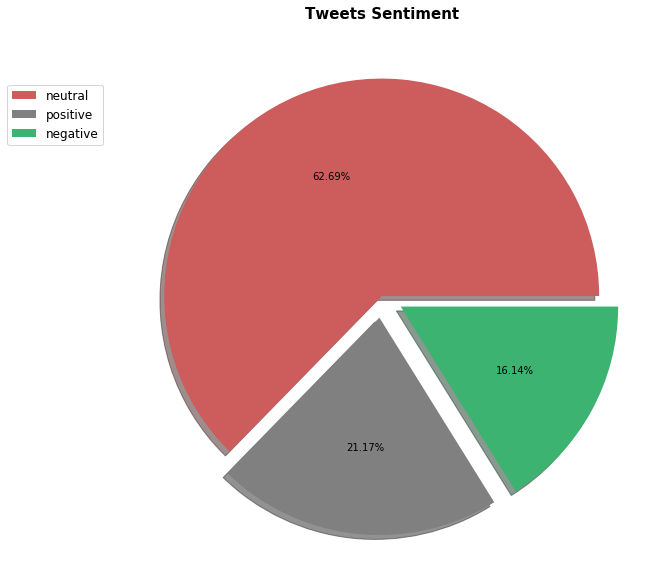

In [46]:
plt.figure(figsize=(18,10))

size = tweets['airline_sentiment'].value_counts().tolist()
colors = ['indianred', 'grey', 'mediumseagreen']
labels = tweets['airline_sentiment'].unique().tolist()
explode = [0, 0.1, 0.1]

plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment', fontweight="bold", fontsize = 15)
plt.axis('off')
plt.legend(labels, bbox_to_anchor=(-0.2,0.9), prop={'size': 12}, loc="upper left")
plt.show()

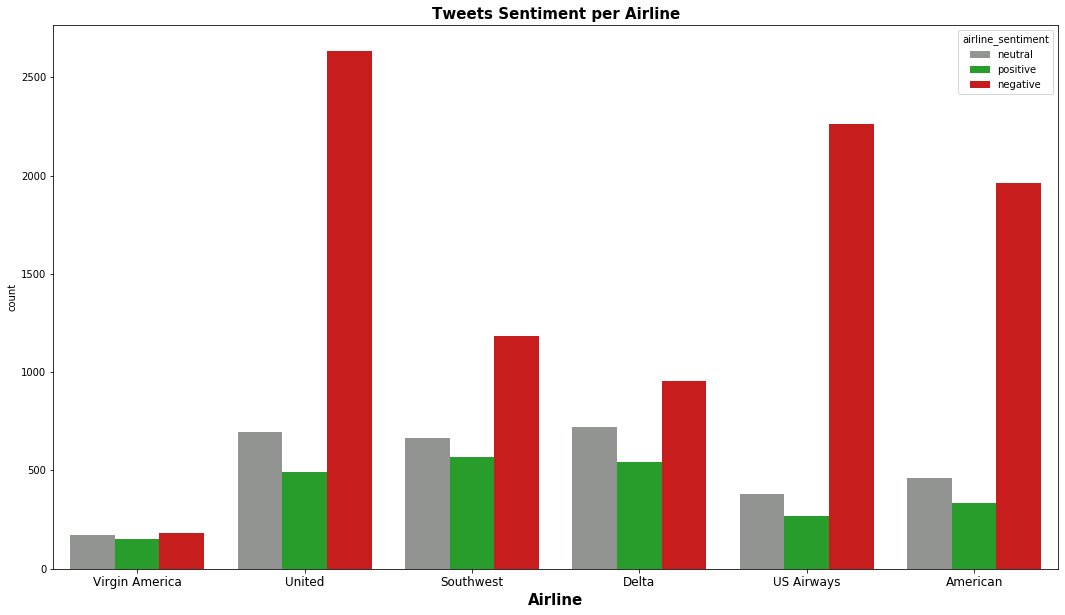

In [83]:
plt.figure(figsize=(18,10))
colors = ['grey', 'green', 'red']
sns.countplot(x = 'airline', hue = 'airline_sentiment', data = tweets, palette=sns.xkcd_palette(colors))
plt.title('Tweets Sentiment per Airline', fontweight="bold", fontsize = 15)
plt.xticks(fontsize = 12)
plt.xlabel('Airline', fontsize = 15, fontweight="bold")
plt.show()

In [50]:
virgin = tweets.loc[tweets['airline'] == 'Virgin America']
united = tweets.loc[tweets['airline'] == 'United']
southwest = tweets.loc[tweets['airline'] == 'Southwest']
delta = tweets.loc[tweets['airline'] == 'Delta']
us = tweets.loc[tweets['airline'] == 'US Airways']
american = tweets.loc[tweets['airline'] == 'American']

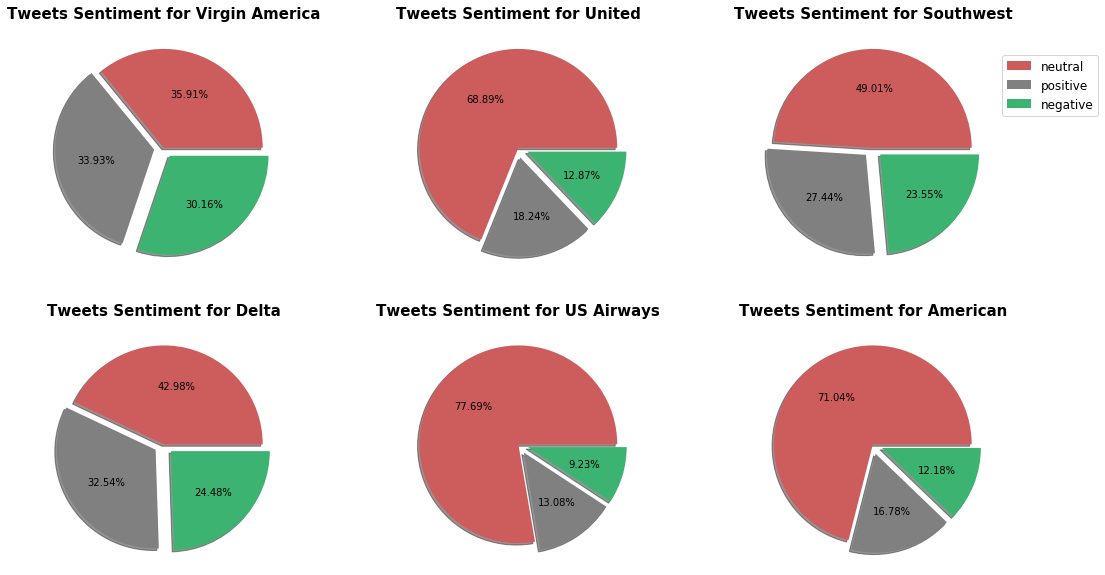

In [99]:
plt.figure(figsize=(18,10))

size = virgin['airline_sentiment'].value_counts().tolist()
colors = ['indianred', 'grey', 'mediumseagreen']
labels = virgin['airline_sentiment'].unique().tolist()
explode = [0, 0.1, 0.1]

plt.subplot(2, 3, 1)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment for Virgin America', fontweight="bold", fontsize = 15)
plt.axis('off')

size = united['airline_sentiment'].value_counts().tolist()

plt.subplot(2, 3, 2)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment for United', fontweight="bold", fontsize = 15)
plt.axis('off')

size = southwest['airline_sentiment'].value_counts().tolist()

plt.subplot(2, 3, 3)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment for Southwest', fontweight="bold", fontsize = 15)
plt.axis('off')
plt.legend(labels, bbox_to_anchor=(1.0,0.9), prop={'size': 12}, loc="upper left")

size = delta['airline_sentiment'].value_counts().tolist()

plt.subplot(2, 3, 4)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment for Delta', fontweight="bold", fontsize = 15)
plt.axis('off')

size = us['airline_sentiment'].value_counts().tolist()

plt.subplot(2, 3, 5)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment for US Airways', fontweight="bold", fontsize = 15)
plt.axis('off')

size = american['airline_sentiment'].value_counts().tolist()

plt.subplot(2, 3, 6)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Tweets Sentiment for American', fontweight="bold", fontsize = 15)
plt.axis('off')
plt.show()

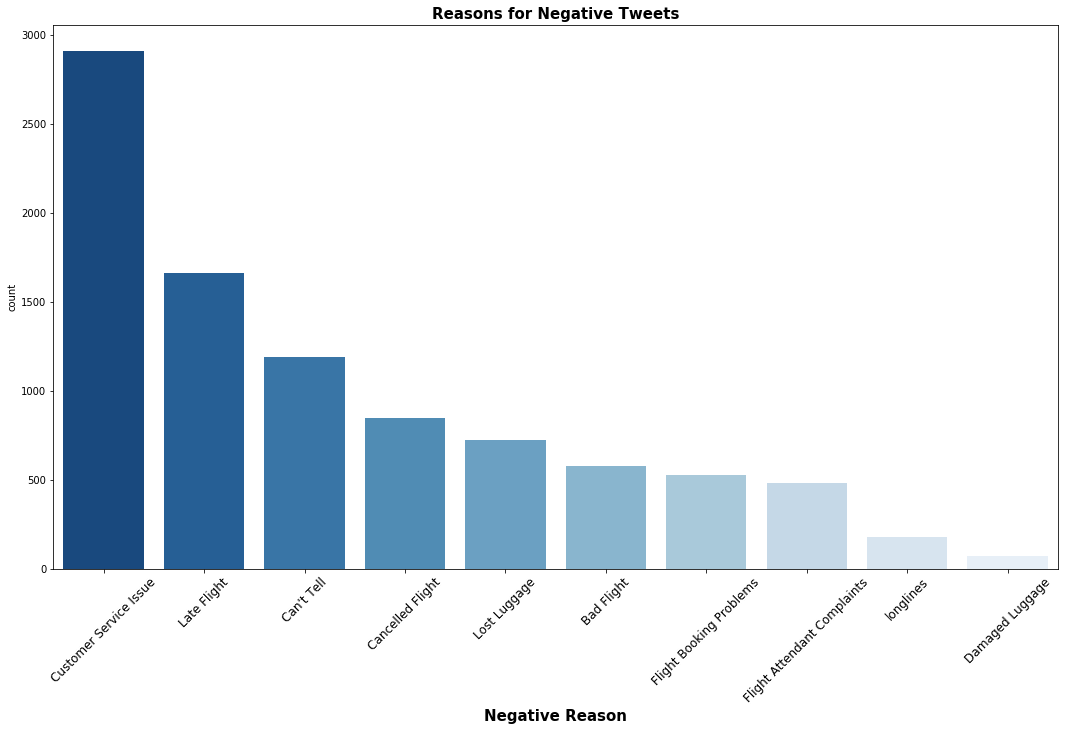

In [84]:
plt.figure(figsize=(18,10))
sns.countplot(x = 'negativereason', data = negative, order = negative['negativereason'].value_counts().index, 
              palette = "Blues_r")
plt.title('Reasons for Negative Tweets', fontweight="bold", fontsize = 15)
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Negative Reason', fontsize = 15, fontweight="bold")
plt.show()


In [92]:
negative_american = negative.loc[(negative['airline'] == 'US Airways') | (negative['airline'] == 'American')]

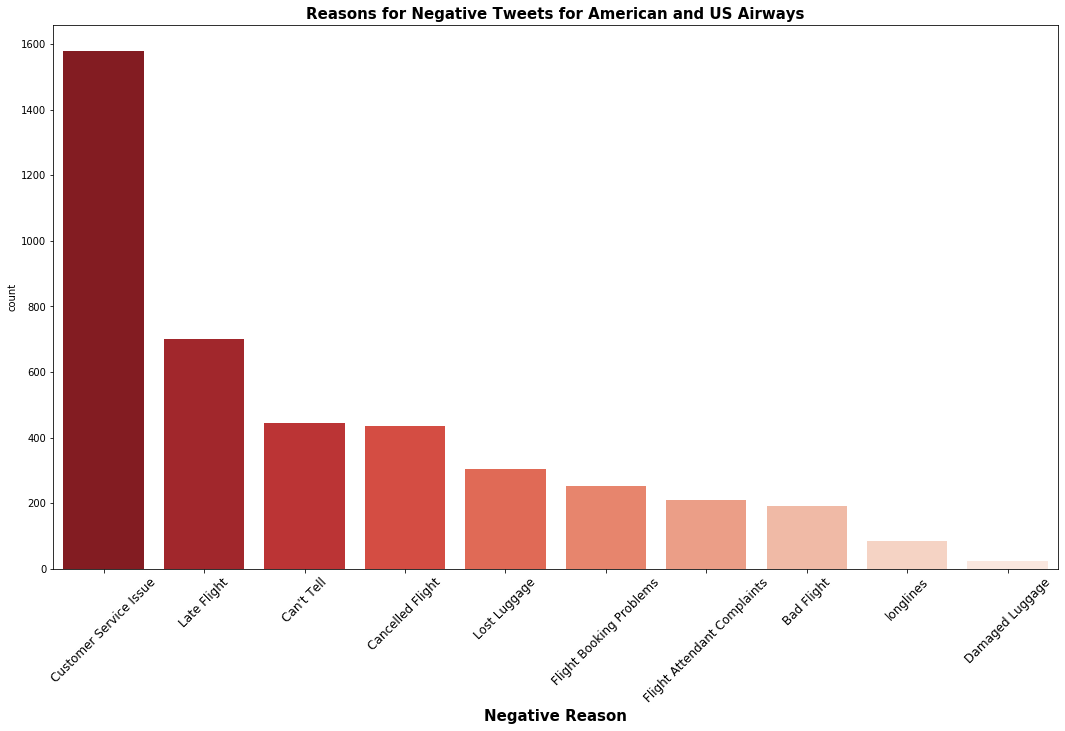

In [95]:
plt.figure(figsize=(18,10))
sns.countplot(x = 'negativereason', data = negative_american, 
              order = negative_american['negativereason'].value_counts().index, palette = "Reds_r")
plt.title('Reasons for Negative Tweets for American and US Airways', fontweight="bold", fontsize = 15)
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Negative Reason', fontsize = 15, fontweight="bold")
plt.show()

In [111]:
cs = negative.loc[negative['negativereason'] == 'Customer Service Issue']
late = negative.loc[negative['negativereason'] == 'Late Flight']
no_clear = negative.loc[negative['negativereason'] == "Can't Tell"]
cancel = negative.loc[negative['negativereason'] == 'Cancelled Flight']
lost = negative.loc[negative['negativereason'] == 'Lost Luggage']
booking = negative.loc[negative['negativereason'] == 'Flight Booking Problems']
fa = negative.loc[negative['negativereason'] == 'Flight Attendant Complaints']
bad = negative.loc[negative['negativereason'] == 'Bad Flight']
lines = negative.loc[negative['negativereason'] == 'longlines']
damaged = negative.loc[negative['negativereason'] == 'Damaged Luggage']

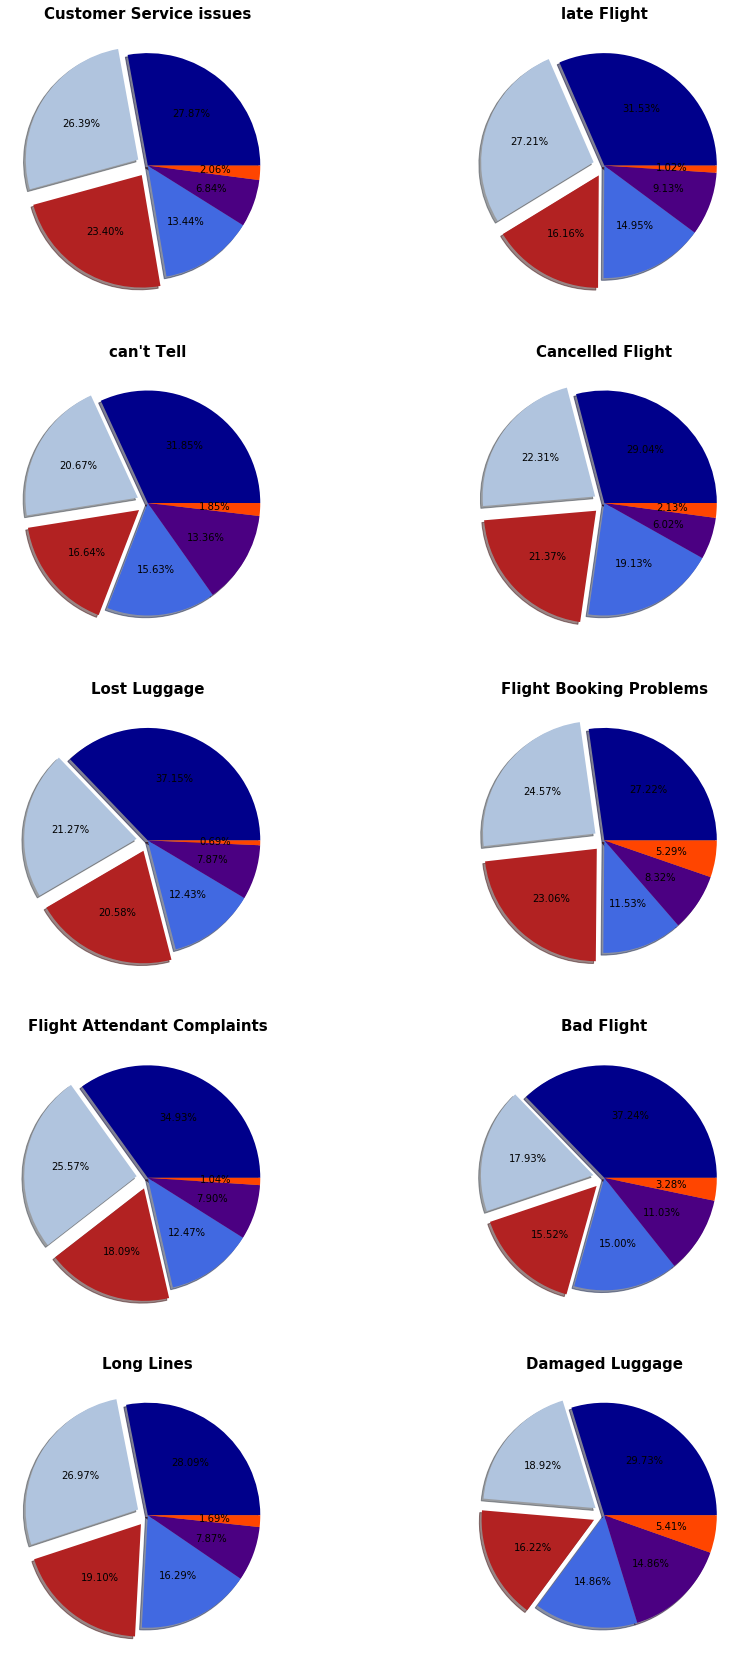

In [152]:
plt.figure(figsize=(15,30))

size = cs['airline'].value_counts().tolist()
colors = ['darkblue', 'lightsteelblue', 'firebrick', 'royalblue', 'indigo', 'orangered']
labels = ['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America']
explode = [0.0, 0.1, 0.1, 0, 0, 0]

plt.subplot(5, 2, 1)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Customer Service issues', fontweight="bold", fontsize = 15)
plt.axis('off')

size = late['airline'].value_counts().tolist()

plt.subplot(5, 2, 2)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('late Flight', fontweight="bold", fontsize = 15)
plt.axis('off')

size = no_clear['airline'].value_counts().tolist()

plt.subplot(5, 2, 3)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title("can't Tell", fontweight="bold", fontsize = 15)
plt.axis('off')

size = cancel['airline'].value_counts().tolist()

plt.subplot(5, 2, 4)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Cancelled Flight', fontweight="bold", fontsize = 15)
plt.axis('off')

size = lost['airline'].value_counts().tolist()

plt.subplot(5, 2, 5)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Lost Luggage', fontweight="bold", fontsize = 15)
plt.axis('off')

size = booking['airline'].value_counts().tolist()

plt.subplot(5, 2, 6)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Flight Booking Problems', fontweight="bold", fontsize = 15)
plt.axis('off')

size = fa['airline'].value_counts().tolist()

plt.subplot(5, 2, 7)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Flight Attendant Complaints', fontweight="bold", fontsize = 15)
plt.axis('off')

size = bad['airline'].value_counts().tolist()

plt.subplot(5, 2, 8)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Bad Flight', fontweight="bold", fontsize = 15)
plt.axis('off')

size = lines['airline'].value_counts().tolist()

plt.subplot(5, 2, 9)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Long Lines', fontweight="bold", fontsize = 15)
plt.axis('off')

size = damaged['airline'].value_counts().tolist()

plt.subplot(5, 2, 10)
plt.pie(size, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Damaged Luggage', fontweight="bold", fontsize = 15)
plt.axis('off')
plt.show()

In [264]:
tweets_american = tweets.loc[(tweets['airline'] == 'US Airways') | (tweets['airline'] == 'American')]

In [151]:
print('Percentage of US Airways and American tweets to Overall tweets =', "{0:.2%}".format(len(tweets_american)/len(tweets)))

Percentage of US Airways and American tweets to Overall tweets = 38.74%


In [265]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\t',' ',text)
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [266]:
# Remove non-essential punctuation from the tweets
pd.options.display.max_colwidth = 200
tweets_american['text'] = tweets_american['text'].map(lambda x: text_cleaner(str(x)))
tweets_american['text'].head()

C:\Users\rabia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8966            @USAirways is there a better time to call? My flight is on Friday and I need to change it. Worried I may be on hold until then.
8967                                                                        @USAirways and when will one of these agents be available to speak?
8968                                                                                    @USAirways is a DM possible if you aren't following me?
8969              @USAirways Fortunately you have staff like Lynn S. and DeeDee who actually understand customer service and simply being NICE.
8970    @USAirways just hung up on me again. Another waste of an hour of my time. How am I supposed to book a one way award flight? #badwebsite
Name: text, dtype: object

In [267]:
# Reduce all text to their lemmas
lemmatizer = WordNetLemmatizer()

for tweet in tweets_american['text']:
    tweet = lemmatizer.lemmatize(tweet)

In [198]:
# Modify values of sentiment to numerical values
sentiment = {'negative': -1, 'neutral': 0, 'positive': 1}
tweets_american['airline_sentiment'] = tweets_american['airline_sentiment'].map(lambda x: sentiment[x])

C:\Users\rabia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [268]:
# Identify our predictor (tweets) and outcome (sentiment) variable
X = tweets_american['text']
y = tweets_american['airline_sentiment']

# Instantiating spaCy
nlp = spacy.load('en_core_web_sm')
X_words = []

# Create list of dataframes that we'll combine later
nlp_methods = []

In [269]:
# Count parts of speech

for row in X:
    row_doc = nlp(row)          # Processing each row for tokens
    sent_len = len(row_doc)     # Calculating length of each sentence

    advs = 0                    # Initializing counts of different parts of speech
    verb = 0
    noun = 0
    adj = 0
    
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

nlp_methods.append(X_counter)

In [270]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,            # Throw out words that occur in over half of tweets
                             min_df=3,              # Words need to apper at least 3 times to count
                             max_features=1200,       
                             stop_words='english',  # Ignore stop words
                             lowercase=True,        # Ignore case
                             use_idf=True,          # Penalize frequent words
                             norm=u'l2',
                             smooth_idf=True        # Add 1 to df in case we have to divide by 0
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

# Append tf-idf vectorizer to our list of nlp methods
nlp_methods.append(X_normal)

In [271]:
## Creating tf-idf matrix
synopsis_tfidf = vectorizer.fit_transform(tweets_american['text'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    top=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        #print('sortedwords ', sortedwords)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        #print('chosen ', chosen)
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str)
        #print('chosenlist ', chosenlist)
        top[column]=[x for x in chosenlist]
        #print('top ', top)
    return(top)

# Number of words to look at for each topic.
n_top_words = 200

# Number of possible outcomes (3 = positive, neutral, negative)
ntopics = tweets_american['airline_sentiment'].nunique()

In [272]:
# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)

In [273]:
# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [274]:
# View top words identified by LSA and NNMF
print('Top positive words: \n\n', topwords[:10], '\n\n')
print('Top neutral words: \n\n', topwords[200:210], '\n\n')
print('Top negative words: \n\n', topwords[400:410])

Top positive words: 

                 LSA             NNMF
0     flight 262.37     flight 21.03
0  cancelled 113.29  cancelled 10.77
0       help 106.75   flightled 7.39
0       hold 101.71        hold 6.25
0       hours 93.94        help 5.95
0        http 81.75       hours 5.57
0        just 81.29     service 4.15
0     service 79.75        need 3.97
0        time 73.96        just 3.53
0        need 73.57    customer 3.33 


Top neutral words: 

               LSA           NNMF
1   thanks 122.35   thanks 24.47
1   service 18.75    flight 1.96
1  customer 16.09     great 1.57
1     great 14.28       got 1.42
1        dm 11.43   service 1.32
1  response 11.06  customer 1.07
1       guys 10.7      http 1.01
1       http 9.72      just 0.99
1        bag 9.11   awesome 0.97
1       just 8.24      help 0.91 


Top negative words: 

               LSA           NNMF
2     thank 90.13    thank 21.67
2   service 63.41     great 1.44
2  customer 55.99  customer 1.33
2      just 26.21   serv

In [275]:
nlp_methods

[             0         1         2         3         4
 0     0.001111  0.003333  0.003333  0.002222  0.999986
 1     0.005917  0.005917  0.005917  0.005917  0.999930
 2     0.000000  0.006944  0.006944  0.006944  0.999928
 3     0.007500  0.002500  0.007500  0.000000  0.999941
 4     0.003122  0.003122  0.007284  0.000000  0.999964
 5     0.004115  0.004115  0.006858  0.002743  0.999956
 6     0.000000  0.015621  0.015621  0.000000  0.999756
 7     0.000000  0.000000  0.008875  0.005917  0.999943
 8     0.000000  0.008888  0.008888  0.004444  0.999911
 9     0.000000  0.004115  0.005487  0.004115  0.999968
 10    0.000000  0.006944  0.005208  0.001736  0.999961
 11    0.001890  0.003780  0.009451  0.003780  0.999939
 12    0.000000  0.006920  0.010380  0.000000  0.999922
 13    0.002551  0.006377  0.006377  0.001275  0.999955
 14    0.004444  0.004444  0.017775  0.000000  0.999822
 15    0.000000  0.002081  0.008324  0.002081  0.999961
 16    0.000000  0.001736  0.010416  0.001736  0